## 문제 6

**Kaggle 형** train_prob.csv로 문제 target을 예측하는 모델을 만들고, 

test_prob.csv에 대한 target 예측하여 다음과 같은 형식의 answer6.csv를 만들어라.

id, target

0, 6.9

5, 7.8

...


**평가지표**

$RMSE(Y, \hat{Y}) = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2}$

**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys
import xgboost as xgb

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels, xgb]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1
xgboost 0.80


In [2]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_test = pd.read_csv('test_prob.csv', index_col='id')
df_ans = pd.read_csv('test_prob_ans.csv', index_col='id')

In [3]:
# 처리 과정에 필요하 내용들을 list 형태로 구성합니다.
repl_list = [
    ('cat3', {'B': 'C'}, [83634, 147361, 9005]),
    ('cat4', {'A': 'B', 'D': 'B'}, [239397, 603]),
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}, [234203, 5145, 652]),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}, [4606, 19784, 214027, 1583]),
    ('cat8', {'B': 'G', 'F': 'E'}, [30338, 96743, 2953, 76085, 33881]),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'}, [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968])
]
# 반복문 처리 내용들을 수행합니다.
for v, d, cnts in repl_list:
    print(v, d, cnts)
    # 치환후 내용을 s_repl에 저장합니다
    s_repl = df_train[v].replace(d)
    # 치환결과를 확인합니다.
    if (s_repl.nunique() != len(cnts)) or ((s_repl.value_counts().sort_index() != cnts).any()):
        print(s_repl.value_counts())
        break
    df_train[v] = s_repl
    df_test[v] = df_test[v].replace(d)
    
cat_cols = ['cat{}'.format(i) for i in range(10)]
cont_cols = ['cont{}'.format(i) for i in range(14)]

cat3 {'B': 'C'} [83634, 147361, 9005]
cat4 {'A': 'B', 'D': 'B'} [239397, 603]
cat6 {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'} [234203, 5145, 652]
cat7 {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'} [4606, 19784, 214027, 1583]
cat8 {'B': 'G', 'F': 'E'} [30338, 96743, 2953, 76085, 33881]
cat9 {'C': 'H', 'D': 'B', 'E': 'L'} [10678, 2846, 85944, 8320, 19987, 40070, 5501, 16743, 33793, 7819, 3331, 4968]


- 일반 문제 발견 점

- PCA 활용: ['cont0', 'cont5', 'cont8', 'cont9', 'cont12']

- targetA 분류: xgb.XGBClassifier ~

- cont_{}_q

- xgb.XGBRegressor: {'colsample_bytree': 0.25, 'n_estimators': 500}

In [4]:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import norm

import os

X_all = df_test.columns.tolist()
df_train['targetA'] = df_train['target'] <= 7.45

# 시간이 오래걸리므로 저장해두고, 저장 결과가 없을 시 실행합니다.
# 실제 시험을 고려한 루틴이기 보다는, 이 노트를 리뷰할 때 좀 더 시간을 절약할 수 있게 고안된 것입니다.
# 처리과정을 재 실행하려면 생성된  targetA_train.csv를 삭제해야 합니다.
if not os.path.isfile('targetA_train.csv'):
    # 문제 3에서 targetA에 대한 예측 모델을 사용합니다,
    df_train_clf = df_train.assign(
        prob_A = 1 - norm.cdf(df_train['target'], loc=6.769, scale=0.616),
        prob_B = norm.cdf(df_train['target'], loc=8.123, scale=0.527)
    ).query('prob_B < 0.01 or prob_A < 0.01').copy()
    
    clf_xgb = make_pipeline( 
        ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('pt', 'passthrough', cont_cols)
        ]),
        xgb.XGBClassifier(
            max_depth = 2, # 트리의 최대 깊이 2
            reg_alpha = 0.1, # L1 규제 0.1
            reg_lambda = 0.1, # L2 규제 0.1
            colsample_bytree=0.25, # 트리 당 컬럼 샘플링 비율 0.25
            n_estimators=500, # 트리의 수 500
            random_state=123, # random_state 123
        )
    )
    
    clf_xgb.fit(df_train_clf[X_all], df_train_clf['targetA'])
    df_targetA_train = pd.DataFrame({'targetA_prob': clf_xgb.predict_proba(df_train[X_all])[:, 1]}, index=df_train.index)
    # 여기까지 처리를 통해서도 어느 정도 효과를 얻을 수 있습니다.
    
    # 두 개의 라인의 처리로 더욱 효과적인 속성이 됩니다.
    # cross_val_predict로 쉽게 할 수 있습니다. 교차 검증시 겹외셋에 대한 예측을 결과를 반환합니다.
    # train셋에 대한 예측 분포가 아닌 train을 제외한 예측에 대한 분포를 지니도록 합니다.
    targetA_prob_cv = cross_val_predict(clf_xgb, df_train_clf[X_all], df_train_clf['targetA'], cv=5, method='predict_proba')
    # df_train_clf에 있는 해당하는 예측은 교차검증의 예측값으로 대체합니다.
    # 이 처리를 했을 때와 안 했을 때의 결과 차이를 확인해보시고면, 그 차이를 체감하실 수 있습니다.
    df_targetA_train.loc[df_targetA_train.index.isin(df_train_clf.index), 'targetA_prob'] = targetA_prob_cv[:, 1]
    
    df_targetA_train.to_csv('targetA_train.csv')
    df_targetA_test = pd.DataFrame({'targetA_prob': clf_xgb.predict_proba(df_test[X_all])[:, 1]}, index=df_test.index)
    df_targetA_test.to_csv('targetA_test.csv')
else:
    # 저장된 결과를 불러옵니다.
    df_targetA_train = pd.read_csv('targetA_train.csv', index_col='id')
    df_targetA_test = pd.read_csv('targetA_test.csv', index_col='id')

In [5]:
df_train['targetA_prob'] = df_targetA_train['targetA_prob']
df_test['targetA_prob'] = df_targetA_test['targetA_prob']

In [6]:
q = [i for i in np.arange(0, 1.01, 0.01)]
# 나머지 변수에 대해서도 해당 파생 변수를 만들어 줍니다.
for i in cont_cols:
    q_val = df_train[i].quantile(q)
    q_val.iloc[[0, -1]] = [-np.inf, np.inf]
    q_cut = pd.cut(df_train[i], bins=q_val)
    q_mean = df_train.groupby(q_cut)['target'].mean()
    df_train[i + '_q'] = q_cut.map(q_mean).astype('float')
    df_test[i + '_q'] = pd.cut(df_test[i], bins=q_val).map(q_mean).astype('float')

In [7]:
s_hist = []

In [8]:
# 공통
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ShuffleSplit, KFold

cv = KFold(n_splits=5, random_state=123)
# train(80%)/test(20%) 한 번으로 검증합니다. XGB, RF등 오래 걸리는 모델을 위해 사용합니다.
ss = ShuffleSplit(n_splits=1, train_size=0.8, random_state=123)

df_ans = pd.read_csv('test_prob_ans.csv', index_col='id')
X_all = df_test.columns.tolist()  + ['targetA_prob']

cat_cols = ['cat{}'.format(i) for i in range(10)]
cont_cols = ['cont{}'.format(i) for i in range(14)]
cont_q_cols = ['cont{}_q'.format(i) for i in range(14)]

# 위에서 발생한 leak을 바로 잡아 교차검증을 합니다.
q = [i for i in np.arange(0, 1.01, 0.01)]
def eval_model(model_name, model, sp):
    score_train, score_valid = list(), list()
    for train_idx, valid_idx in sp.split(df_train):
        df_cv_train, df_valid = df_train.iloc[train_idx].copy(), df_train.iloc[valid_idx].copy()
        # 시험에서 구현하기 어려울 수 있으니, 시험 때는 leakage가 있어 성능에 측정에 왜곡이 있음을 고려하고 cross_validate를 
        # 사용해서 구성을 해도 됩니다.
        # 검증셋에서 train으로 파생변수를 만들고
        # 검증셋의 test(겹외셋)에 검증셋의 train으로 만든 통계값(mean)을 반영합니다.
        for i in cont_cols:
            q_val =  df_cv_train[i].quantile(q)
            q_val.iloc[[0, -1]] = [-np.inf, np.inf]
            q_cut = pd.cut(df_cv_train[i], bins=q_val)
            q_mean = df_cv_train.groupby(q_cut)['target'].mean()
            df_cv_train[i + '_q'] = q_cut.map(q_mean).astype('float')
            df_valid[i + '_q'] = pd.cut(df_valid[i], bins=q_val).map(q_mean).astype('float')
        model.fit(df_cv_train[X_all], df_cv_train['target'])
        score_valid.append((mean_squared_error(df_valid['target'], model.predict(df_valid[X_all]))) ** 0.5)
        score_train.append((mean_squared_error(df_cv_train['target'], model.predict(df_cv_train[X_all]))) ** 0.5)
        
    output = 'Valid: {:.5f}±{:.5f},  V.Train: {:.5f}±{:.5f}'.format( 
            np.mean(score_valid), np.std(score_valid),
            np.mean(score_train), np.std(score_train),
        )
    print(output)
    s_hist.append(pd.Series([model_name, output, np.mean(score_valid)], index=['model name', 'result', 'score']))
    df_result = pd.DataFrame(s_hist)
    display(df_result.groupby('model name').last())
    display(df_result.loc[df_result['score'].idxmin()])

def select_model(model):
    model.fit(df_train[X_all], df_train['target'])
    prd = model.predict(df_test[X_all])
    pd.DataFrame({
        'id': df_test.index.values,
        'target': prd
    }).to_csv('answer6.csv', index = None)
    return prd 

In [9]:
from sklearn.linear_model import LinearRegression
# 아무처리 없이 사용합니다.
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('std', StandardScaler(), cont_cols)
])

reg_lr = make_pipeline(ct, LinearRegression())
eval_model('baseline', reg_lr, cv)

Valid: 0.86325±0.00295,  V.Train: 0.86300±0.00073


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246


model name                                             baseline
result        Valid: 0.86325±0.00295,  V.Train: 0.86300±0.00073
score                                                  0.863246
Name: 0, dtype: object

In [10]:
prd = select_model(reg_lr)
print("baseline 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

baseline 채점 결과: 0.8657267201878256


In [11]:
# + targetA_prob 를 추가합니다.
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('std', StandardScaler(), cont_cols),
    ('pt', 'passthrough', ['targetA_prob'])
])

reg_lr2 = make_pipeline(ct, LinearRegression())
eval_model('lr2', reg_lr2, cv)

Valid: 0.84700±0.00284,  V.Train: 0.84671±0.00072


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998


model name                                                  lr2
result        Valid: 0.84700±0.00284,  V.Train: 0.84671±0.00072
score                                                  0.846998
Name: 1, dtype: object

In [12]:
prd = select_model(reg_lr2)
print("lr2 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

lr2 채점 결과: 0.8491929478701575


In [13]:
# + targetA_prob 를 추가합니다.
# + cont{}_q 를 cont{} 대신에 사용합니다.

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('std', StandardScaler(), cont_q_cols),
    ('pt', 'passthrough', ['targetA_prob'])
])

reg_lr3 = make_pipeline(ct, LinearRegression())
eval_model('lr3', reg_lr3, cv)

Valid: 0.84624±0.00276,  V.Train: 0.84338±0.00092


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998
lr3,"Valid: 0.84624±0.00276, V.Train: 0.84338±0.00092",0.846243


model name                                                  lr3
result        Valid: 0.84624±0.00276,  V.Train: 0.84338±0.00092
score                                                  0.846243
Name: 2, dtype: object

In [14]:
prd = select_model(reg_lr3)
print("lr3 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

lr3 채점 결과: 0.8481215742060655


In [15]:
# + targetA_prob 를 추가합니다.
# PCA + cont{}_q 를 cont{} 대신에 사용합니다.

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), cat_cols),
    ('std', make_pipeline(StandardScaler(), PCA(n_components=0.95)), cont_q_cols),
    ('pt', 'passthrough', ['targetA_prob'])
])
reg_lr4 = make_pipeline(
    ct, 
    LinearRegression()
)
eval_model('lr4', reg_lr4, cv)

Valid: 0.84625±0.00279,  V.Train: 0.84338±0.00074


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998
lr3,"Valid: 0.84624±0.00276, V.Train: 0.84338±0.00092",0.846243
lr4,"Valid: 0.84625±0.00279, V.Train: 0.84338±0.00074",0.846246


model name                                                  lr3
result        Valid: 0.84624±0.00276,  V.Train: 0.84338±0.00092
score                                                  0.846243
Name: 2, dtype: object

In [16]:
prd = select_model(reg_lr4)
print("lr4 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

lr4 채점 결과: 0.848121966353479


In [17]:
from sklearn.ensemble import RandomForestRegressor

ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols),
    ('pt', 'passthrough', cont_cols + ['targetA_prob'])
])

reg_rf = make_pipeline(
    ct,
    RandomForestRegressor(n_estimators=50, max_depth=4, random_state=123, n_jobs=4) # Kaggle에서는 멀티프로세싱을 해도 됩니다.
)
# RandomForestRegressor는 학습에 오래걸립니다. 
# 검증 방법을 교차검증에서 Hold Out (Shuffle Split n_splits=1) 검증으로 바꿉니다.
eval_model('rf', reg_rf, ss)

Valid: 0.84655±0.00000,  V.Train: 0.84634±0.00000


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998
lr3,"Valid: 0.84624±0.00276, V.Train: 0.84338±0.00092",0.846243
lr4,"Valid: 0.84625±0.00279, V.Train: 0.84338±0.00074",0.846246
rf,"Valid: 0.84655±0.00000, V.Train: 0.84634±0.00000",0.846550


model name                                                  lr3
result        Valid: 0.84624±0.00276,  V.Train: 0.84338±0.00092
score                                                  0.846243
Name: 2, dtype: object

In [18]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols),
    ('pt', 'passthrough', cont_cols + ['targetA_prob'])
])
reg_xgb = make_pipeline(
    ct,
    xgb.XGBRegressor(n_estimators=150, max_depth=2, random_state=123, n_jobs=4)
)
# Hold Out (Shuffle Split n_splits=1) 검증을 사용합니다.
eval_model('xgb', reg_xgb, ss)

Valid: 0.84615±0.00000,  V.Train: 0.84477±0.00000


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998
lr3,"Valid: 0.84624±0.00276, V.Train: 0.84338±0.00092",0.846243
lr4,"Valid: 0.84625±0.00279, V.Train: 0.84338±0.00074",0.846246
rf,"Valid: 0.84655±0.00000, V.Train: 0.84634±0.00000",0.846550
xgb,"Valid: 0.84615±0.00000, V.Train: 0.84477±0.00000",0.846149


model name                                                  xgb
result        Valid: 0.84615±0.00000,  V.Train: 0.84477±0.00000
score                                                  0.846149
Name: 5, dtype: object

In [19]:
# 한 번 채점은 해봅니다.
prd = select_model(reg_xgb)
print("xgb 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

xgb 채점 결과: 0.8480732829872999


In [20]:
# Voting을 통한 앙상블을 만듭니다.
from sklearn.ensemble import VotingRegressor

reg_vt = VotingRegressor([
    #('baseline', reg_lr),
    #('lr2', reg_lr2),
    ('lr3', reg_lr3),
    ('lr4', reg_lr4),
    #('rf', reg_rf),
    ('xgb', reg_xgb),
])
eval_model('vt', reg_vt, ss)

Valid: 0.84545±0.00000,  V.Train: 0.84299±0.00000


,result,score
model name,,
baseline,"Valid: 0.86325±0.00295, V.Train: 0.86300±0.00073",0.863246
lr2,"Valid: 0.84700±0.00284, V.Train: 0.84671±0.00072",0.846998
lr3,"Valid: 0.84624±0.00276, V.Train: 0.84338±0.00092",0.846243
lr4,"Valid: 0.84625±0.00279, V.Train: 0.84338±0.00074",0.846246
rf,"Valid: 0.84655±0.00000, V.Train: 0.84634±0.00000",0.846550
vt,"Valid: 0.84545±0.00000, V.Train: 0.84299±0.00000",0.845455
xgb,"Valid: 0.84615±0.00000, V.Train: 0.84477±0.00000",0.846149


model name                                                   vt
result        Valid: 0.84545±0.00000,  V.Train: 0.84299±0.00000
score                                                  0.845455
Name: 6, dtype: object

In [21]:
# 개선이 있습니다 모델을 선택합니다. 
prd = select_model(reg_vt)
# 자가 채점을 해봅니다.
print("Voting 채점 결과:",  mean_squared_error(df_ans['target'], prd) ** 0.5)

Voting 채점 결과: 0.8474262891304022


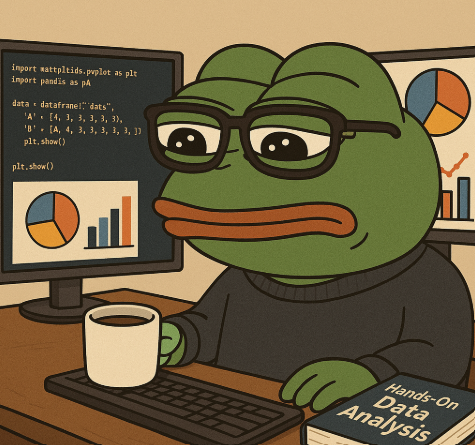

3 일간 고생 많으셨습니다. 

좋은 성과를 얻으시길 바랍니다,

문의 사항 있으시면 언제든지 연락 주세요. 감사합니다.

**멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com) 올림**